In [40]:
import torch
import tiktoken


In [41]:
tokenizer = tiktoken.get_encoding( "gpt2" )
text = ( "Hello World ")
integers = tokenizer.encode( text )
print ( integers ) 

[15496, 2159, 220]


In [42]:
import torch 
import torch.nn as nn

In [43]:
### Layer Normalisation and Feed Forward Neural Network
class LayerNorm( nn.Module ):
    def __init__( self , emb_dim ):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter( torch.ones( emb_dim ))
        self.shift = nn.Parameter( torch.zeros( emb_dim ))


    def forward( self , x ):
        mean = x.mean( dim = -1 , keepdim = True )
        var = x.var( dim = -1 , keepdim = True , unbiased = True )
        norm_x = ( x - mean ) / torch.sqrt( var + self.eps )
        return self.scale * norm_x + self.shift
    

class GELU( nn.Module ):
    def __init__( self  ):
        super().__init__()

    def forward( self , x ):
        return 0.5 * x * ( 1 + torch.tanh( 
            torch.sqrt( torch.tensor( 2.0 / torch.pi )) * 
            ( x + 0.044715 * torch.pow( x , 3 )) 
        ))

class FeedForward( nn.Module ):
    def __init__( self , cfg ):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear( cfg["emb_dim" ] , 4 * cfg["emb_dim" ] ),
            GELU(),
            nn.Linear( 4 * cfg[ "emb_dim"] , cfg[ "emb_dim" ]),

        )

    def forward( self , x ):
        return self.layers( x )

In [44]:
### MutiHead Attention Mech
class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

In [45]:
### Transformer Class
class TransformerBlock( nn.Module ):
    def __init__( self , cfg ):
        super().__init__()
        self.att = MultiHeadAttention( 
            d_in = cfg[ "emb_dim"],
            d_out = cfg[ "emb_dim"],
            context_length = cfg[ "context_length"],
            num_heads = cfg[ "n_heads"],
            dropout = cfg[ "drop_rate"],
            qkv_bias = cfg[ "qkv_bias"],

        )
        self.ff = FeedForward( cfg )
        self.norm1 = LayerNorm( cfg[ "emb_dim"])
        self.norm2 = LayerNorm( cfg[ "emb_dim"])
        self.drop_shortcut = nn.Dropout( cfg["drop_rate"])

    def forward( self , x ):
        shortcut = x
        x = self.norm1( x )
        x = self.att( x )
        x = self.drop_shortcut( x )
        x = x + shortcut

        shortcut = x
        x = self.norm2( x )
        x = self.ff( x )
        x = self.drop_shortcut( x )
        x = x + shortcut


        return x

In [46]:
### Now to Code the GPT Architecture
class GPTModel( nn.Module ):
    def __init__(self , cfg ):
        super().__init__()
        self.tok_emb = nn.Embedding( cfg["vocab_size"] , cfg["emb_dim"])
        self.pos_emb = nn.Embedding( cfg["context_length" ] , cfg["emb_dim"])
        self.drop_emb = nn.Dropout( cfg["drop_rate"])

        self.trf_blocks = nn.Sequential( 
            *[TransformerBlock( cfg ) for _ in range(cfg[ "n_layers"])])
        
        self.final_norm = LayerNorm( cfg["emb_dim"])
        self.out_head = nn.Linear(
            cfg["emb_dim"] , cfg[ "vocab_size"], bias=  False
        )

    def forward( self , in_idx ):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb( in_idx )
        pos_embeds = self.pos_emb( torch.arange( seq_len , device = in_idx.device ))
        x = tok_embeds + pos_embeds
        x = self.drop_emb( x )
        x = self.trf_blocks( x )
        x = self.final_norm( x )
        logits = self.out_head( x )
        return logits

In [47]:
def text_to_token_ids( text , tokenizer ):
    encoded = tokenizer.encode( text , allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor( encoded ).unsqueeze( 0 )
    return encoded_tensor

def token_ids_to_text( token_ids , tokenizer ):
    flat = token_ids.squeeze( 0 )
    return tokenizer.decode( flat.tolist())

## Loading Pretrained weights from Open AI

In [48]:
## Loading Pretrained weights from Open AI
%pip install tensorflow
%pip install tqdm
%pip install tensorflow>=2.15.0 tqdm>=4.66

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
zsh:1: 2.15.0 not found
Note: you may need to restart the kernel to use updated packages.


In [49]:
import tensorflow as tf
import tqdm

print( "Tensorflow version ", tf.__version__ )
print( "tqdm Version ", tqdm.__version__ )


Tensorflow version  2.18.0
tqdm Version  4.67.1


In [50]:
def assign( left , right ):
    if left.shape != right.shape:
        raise ValueError( f"Shape mismatched. Left: { left.shape } , Right : { right.shape }")
    
    return torch.nn.Parameter( torch.tensor( right ))

In [90]:
# Now link the GPT Model class with the downloaded weights
# import numpy as np

# def load_weight_into_gpt( gpt , params ):
#     gpt.pos_emb.weight = assign( gpt.pos_emb.weight , params[ 'wpe'])
#     gpt.tok_emb.weight = assign( gpt.tok_emb.weight , params[ 'wte'])

#     for b in range( len( params[ 'blocks'])):
#         # weight part 
#         q_w, k_w , v_w = np.split(
#             (params["blocks"][b]["attn"]["c_attn"])["w"] , 3 , axis = -1 )
#         gpt.trf_blocks[b].att.W_query.weight = assign( gpt.trf_blocks[b].att.W_query.weight , q_w.T )
#         gpt.trf_blocks[b].att.W_key.weight = assign(  gpt.trf_blocks[b].att.W_key.weight , k_w.T)
#         gpt.trf_blocks[b].att.W_value.weight = assign( gpt.trf_blocks[b].att.W_value.weight , v_w.T )

#         # bias part 
#         q_b , k_b , v_b = np.split(
#             (params["blocks"][b]["attn"]["c_attn"])["b"] , 3 , axis = -1
#         )
#         gpt.trf_blocks[b].att.W_query.bias = assign( gpt.trf_blocks[b].att.W_query.bias , q_b )
#         gpt.trf_blocks[b].att.W_key.bias = assign(  gpt.trf_blocks[b].att.W_key.bias , k_b )
#         gpt.trf_blocks[b].att.W_value.bias = assign( gpt.trf_blocks[b].att.W_value.bias , v_b )

#         # output project weight 
#         gpt.trf_blocks[b].att.out_proj.weight = assign( gpt.trf_blocks[b].att.out_proj.weight , params["blocks"][b]["attn"]["c_proj"]["w"].T )
#         gpt.trf_blocks[b].att.out_proj.bias = assign( gpt.trf_blocks[b].att.out_proj.bias , params["blocks"][b]["attn"]["c_proj"]["b"] )

#         # Feed Forward NN -> Fully connected layer
#         gpt.trf_blocks[b].ff.layers[0].weight = assign( gpt.trf_blocks[b].ff.layers[0].weight , params["blocks"][b]["mlp"]["c_fc"]["w"].T )
#         gpt.trf_blocks[b].ff.layers[0].bias = assign( gpt.trf_blocks[b].ff.layers[0].bias , params["blocks"][b]["mlp"]["c_fc"]["b"] )
#         # Projection layer 
#         gpt.trf_blocks[b].ff.layers[2].weight = assign( gpt.trf_blocks[b].ff.layers[2].weight , params["blocks"][b]["mlp"]["c_proj"]["w"].T )
#         gpt.trf_blocks[b].ff.layers[2].bias = assign( gpt.trf_blocks[b].ff.layers[2].bias , params["blocks"][b]["mlp"]["c_proj"]["b"] )

#         # layer normalisation 1 and 2
#         gpt.trf_blocks[b].norm1.scale = assign( gpt.trf_blocks[b].norm1.scale , params["blocks"][b]["ln_1"]["g"] )
#         gpt.trf_blocks[b].norm1.shift = assign( gpt.trf_blocks[b].norm1.shift , params["blocks"][b]["ln_1"]["b"] )

#         gpt.trf_blocks[b].norm2.scale = assign( gpt.trf_blocks[b].norm2.scale , params["blocks"][b]["ln_1"]["g"] )
#         gpt.trf_blocks[b].norm2.shift = assign( gpt.trf_blocks[b].norm2.shift , params["blocks"][b]["ln_1"]["b"] )

#     # Final parameters left affter transformer block
#     gpt.final_norm.scale = assign( gpt.final_norm.scale , params["g"] )
#     gpt.final_norm.shift = assign( gpt.final_norm.shift , params["b"] )
#     gpt.out_head.weight = assign( gpt.out_head.weight , params["wte"])
    


import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])
    
    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight, 
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias, 
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight, 
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias, 
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight, 
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias, 
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale, 
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift, 
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale, 
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift, 
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])



## Fine Tuning for Classification - Classification

In [52]:
## Fine Tuning for Classification - Classification
import urllib.request
import ssl
import zipfile
import os
from pathlib import Path

url = "https://archive.ics.uci.edu/dataset/228/sms+spam+collection.zip"
zip_path = "/Users/adityaastronomy/Desktop/LLM/sms_spam_collection.zip"
extracted_path = "/Users/adityaastronomy/Desktop/LLM/sms_spam_collection"
data_file_path = Path( extracted_path ) / "SMSSpamCollection.tsv"

def download_and_unzip_spam_data( url , zip_path , extracted_path , data_file_path ):
    if data_file_path.exists():
        print( f"{ data_file_path } already exist, skipping the Download Part ")
        return 
    
    # create an unverifed SSL Content
    ssl_context = ssl._create_unverified_context()

    # Download the file 
    with urllib.request.urlopen( url , context = ssl_context ) as response :
        with open( zip_path , "wb" ) as out_file : 
            out_file.write( response.read())

    #unzipping the file
    with zipfile.ZipFile( zip_path , "r" ) as zip_ref:
        zip_ref.extractall( extracted_path )

    #Add .tsv file extension 
    original_file_path = Path( extracted_path ) / "SMSSpamCollection"
    os.rename( original_file_path , data_file_path )
    print( f"file downloaded and saved as { data_file_path }")


download_and_unzip_spam_data( url , zip_path , extracted_path , data_file_path )

## Download this Mannually from the site 


/Users/adityaastronomy/Desktop/LLM/sms_spam_collection/SMSSpamCollection.tsv already exist, skipping the Download Part 


In [53]:
# %pip install pandas
import pandas as pd
df = pd.read_csv( data_file_path , sep = "\t" , header = None , names = ["Labels" , "Text"])
df

,Labels,Text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."
...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...
5568,ham,Will ü b going to esplanade fr home?
5569,ham,"Pity, * was in mood for that. So...any other s..."
5570,ham,The guy did some bitching but I acted like i'd...


In [54]:
print( df["Labels"].value_counts())

Labels
ham     4825
spam     747
Name: count, dtype: int64


In [55]:
# This is imbalance data set , now lets make it a balanced data set 
# so we randomly take 747 data ebtries from spam and no spam part 

def create_balanced_dataset( df ):

    num_spam = df[df["Labels"] == "spam"].shape[0]

    # Randomly select 
    ham_subset = df[ df["Labels"] == "ham"].sample( num_spam , random_state = 123 )

    balanced_df = pd.concat( [ ham_subset , df[df["Labels"] == "spam"]])

    return balanced_df 

balanced_df = create_balanced_dataset( df )
print( balanced_df["Labels"].value_counts())
print( balanced_df )

Labels
ham     747
spam    747
Name: count, dtype: int64
     Labels                                               Text
4307    ham  Awww dat is sweet! We can think of something t...
4138    ham                             Just got to  &lt;#&gt;
4831    ham  The word "Checkmate" in chess comes from the P...
4461    ham  This is wishing you a great day. Moji told me ...
5440    ham      Thank you. do you generally date the brothas?
...     ...                                                ...
5537   spam  Want explicit SEX in 30 secs? Ring 02073162414...
5540   spam  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547   spam  Had your contract mobile 11 Mnths? Latest Moto...
5566   spam  REMINDER FROM O2: To get 2.50 pounds free call...
5567   spam  This is the 2nd time we have tried 2 contact u...

[1494 rows x 2 columns]


In [56]:
balanced_df["Labels"] = balanced_df["Labels"].map( { "ham" : 0 , "spam" : 1 })

In [57]:
print( balanced_df )

      Labels                                               Text
4307       0  Awww dat is sweet! We can think of something t...
4138       0                             Just got to  &lt;#&gt;
4831       0  The word "Checkmate" in chess comes from the P...
4461       0  This is wishing you a great day. Moji told me ...
5440       0      Thank you. do you generally date the brothas?
...      ...                                                ...
5537       1  Want explicit SEX in 30 secs? Ring 02073162414...
5540       1  ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547       1  Had your contract mobile 11 Mnths? Latest Moto...
5566       1  REMINDER FROM O2: To get 2.50 pounds free call...
5567       1  This is the 2nd time we have tried 2 contact u...

[1494 rows x 2 columns]


In [58]:
#Splitin the data set as 70 % - training , 10 % - validation and 20 % -test 
def random_split( df , train_frac , validation_frac ):

    df = df.sample( frac= 1 , random_state= 123 ).reset_index( drop = True )

    train_end = int( len(df) * train_frac )
    validation_end = train_end + int( len( df ) * validation_frac )

    # Diving the df
    train_df = df[ : train_end ]
    validation_df = df[ train_end : validation_end ]
    test_df = df[ validation_end : ]

    return train_df , validation_df , test_df

train_df , validation_df , test_df = random_split( balanced_df , 0.7 , 0.1 )


In [59]:
print( len( train_df ))
print( len( validation_df ))
print( len( test_df ))

1045
149
300


In [60]:
# Now save the dataset 
train_df.to_csv( "train.csv" , index = None )
validation_df.to_csv( "validation.csv" , index = None )
test_df.to_csv( "test.csv" , index = None )

In [61]:
# Creating Data Loaders
import torch 
from torch.utils.data import Dataset

class SpamDataset( Dataset ):
    def __init__( self , csv_file , tokenizer , max_length = None , pad_token_id = 50256 ):
        self.data = pd.read_csv( csv_file )

        # Pre tokenize text 
        self.encoded_texts = [
            tokenizer.encode( text ) for text in self.data["Text"]
        ]

        if max_length is None:
            self.max_length = self._longest_encoded_length()

        else:
            self.max_length = max_length

            # Truncate the seq 
            self.encoded_texts = [
                encoded_text[ : self.max_length ]
                for encoded_text in self.encoded_texts 
            ]

        # Padding
        self.encoded_texts = [ encoded_text + [ pad_token_id ] * ( self.max_length - len( encoded_text ))
                              for encoded_text in self.encoded_texts 
                              ]
        
    def __getitem__( self , index ):
        encoded = self.encoded_texts[ index ]
        label = self.data.iloc[ index ][ 'Labels']
        return (
            torch.tensor( encoded , dtype = torch.long ),
            torch.tensor( label , dtype = torch.long )
        )
    
    def __len__( self ):
        return len( self.data )
    
    def _longest_encoded_length( self ):
        max_length = 0
        for encoded_text in self.encoded_texts : 
            encoded_length = len( encoded_text )
            if( encoded_length > max_length ):
                max_length = encoded_length
        return max_length



In [62]:
train_dataset = SpamDataset(
    csv_file= "train.csv",
    max_length= None ,
    tokenizer= tokenizer
)

print( train_dataset.max_length)

120


In [63]:
val_dataset = SpamDataset(
    csv_file = "validation.csv",
    max_length= train_dataset.max_length,
    tokenizer= tokenizer
)

test_dataset = SpamDataset(
    csv_file= "test.csv",
    max_length= train_dataset.max_length,
    tokenizer= tokenizer
)

In [64]:
# Now the data set will be served as a input to the dataloader 
from torch.utils.data import DataLoader

num_wokers = 0
batch_size = 8

torch.manual_seed( 123 )
train_loader = DataLoader(
    dataset= train_dataset , 
    batch_size= batch_size , 
    num_workers= num_wokers,
    drop_last= True,
)

val_loader = DataLoader(
    dataset= val_dataset ,
    batch_size= batch_size ,
    num_workers= num_wokers,
    drop_last= False,
)

test_loader = DataLoader(
    dataset= test_dataset ,
    batch_size= batch_size ,
    num_workers= num_wokers,
    drop_last= False,
)

In [65]:
print("Train Loader : ")

for input_batch , target_batch in train_loader :
    pass

print( "Input Batch Dimension :" , input_batch.shape )
print( "Target Batch Dimension :" , target_batch.shape )

Train Loader : 
Input Batch Dimension : torch.Size([8, 120])
Target Batch Dimension : torch.Size([8])


In [66]:
print( f"{len (train_loader )} training batches ")
print( f"{len(val_loader) } validation batches ")
print( f"{len(test_loader) } test batches ")

130 training batches 
19 validation batches 
38 test batches 


## Initialising the model with GPT 2 weights


In [82]:
CHOOSE_MODEL = "gpt2-small (124M)"
INPUT_PROMPT = "Every effort moves "
BASE_CONFIG = {
    "vocab_size" : 50257,
    "context_length" : 1024,
    "drop_rate" : 0.0,
    "qkv_bias" : True
}
model_configs = {
    "gpt2-small (124M)" : { "emb_dim" : 768 , "n_layers" : 12 , "n_heads" : 12 },
    "gpt2-medium (355M)" : { "emb_dim" : 1024 , "n_layers" : 24 , "n_heads" : 16 }, 
    "gpt2-large (774M)" : { "emb_dim" : 1280 , "n_layers" : 36 , "n_heads" : 20 }, 
    "gpt2-xl (1558M)" : { "emb_dim" : 1600 , "n_layers" : 48 , "n_heads" : 25 }, 
}

BASE_CONFIG.update( model_configs[CHOOSE_MODEL])

assert train_dataset.max_length <= BASE_CONFIG["context_length"], (
    f"Data Set length {train_dataset.max_length } exceeds the model's context length "
    f"length {BASE_CONFIG["context_length"]}. Reinitialise data set with "
    f"`max_length ={ BASE_CONFIG["context_length"] }`"
)

In [83]:
model_size = CHOOSE_MODEL.split(" ")[ - 1 ].lstrip("(").rstrip(")")

from gpt_download3 import download_and_load_gpt2

settings , params = download_and_load_gpt2( model_size= model_size , models_dir= "gpt2")
print( "Setting : ", settings)
print( 'Parameter dictionary keys : ' , params.keys())


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/checkpoint


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/encoder.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/hparams.json


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.data-00000-of-00001


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.index


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/model.ckpt.meta


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/urllib3/connectionpool.py:1097: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openaipublic.blob.core.windows.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/latest/advanced-usage.html#tls-warnings
  warnings.warn(


File already exists and is up-to-date: gpt2/124M/vocab.bpe
Setting :  {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}
Parameter dictionary keys :  dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


## Initialising the model with GPT 2 weights


In [91]:
model = GPTModel( BASE_CONFIG )
load_weights_into_gpt( model , params )
model.eval();

In [92]:
def text_to_token_ids( text , tokenizer ):
    encoded = tokenizer.encode( text , allowed_special = {'<|endoftext|>'})
    encoded_tensor = torch.tensor( encoded ).unsqueeze( 0 )
    return encoded_tensor

def token_ids_to_text( token_ids , tokenizer ):
    flat = token_ids.squeeze( 0 )
    return tokenizer.decode( flat.tolist())

In [93]:
def generate_text_sample( model , idx , max_new_tokens , context_size ):
    # idx is the ( batch , n_tokens ) array of the indices in the current context
    for _ in range( max_new_tokens ):
        idx_cond = idx[:, -context_size: ]
        with torch.no_grad():
            logits = model( idx_cond )

        logits = logits[ :, -1, :]

        probas = torch.softmax( logits , dim = -1 )
    
        idx_next = torch.argmax( probas , dim = -1 , keepdim = True )

        idx = torch.cat((idx , idx_next ), dim = 1 )

    return idx

In [94]:
text1 = "Every effort moves you "
token_ids = generate_text_sample(
    model = model ,
    idx = text_to_token_ids( text1 , tokenizer ),
    max_new_tokens= 15 , 
    context_size= BASE_CONFIG["context_length"]
)

print( token_ids_to_text( token_ids , tokenizer ))

Every effort moves you  to the next step.
The first step is to find the right


In [96]:
# Lets check that our base model can classify the given mail as spam or no spam 
text2 = (
    "Is the following text 'spam'? Answer with 'Yes' or 'No"
    "'You are a winner you have been specially"
    "selected for receive $10000 cash or $2000 award. '"
)

token_ids = generate_text_sample(
    model = model ,
    idx = text_to_token_ids( text2 , tokenizer ),
    max_new_tokens= 23 , 
    context_size= BASE_CONFIG["context_length"]
)

print( token_ids_to_text( token_ids , tokenizer ))

Is the following text 'spam'? Answer with 'Yes' or 'No'You are a winner you have been speciallyselected for receive $10000 cash or $2000 award. 'Spam' means spamming or sending unwanted or unwanted messages. 'Spam' means spamming or sending unwanted


#### model fail to give the correct output because it has only under gone pretraining not fine tuning


In [ ]:
# Final Output Layer is now changed from dimension - 768 * 50257 to 768 * 2 for predicting spam or no spam
# Therfore we are fine tuing inky the final transformer block

# finetune :
    # - Final Output Layer
    # - Final Transformer Block 
    # - Final Layer Normal Module 


## Adding a classification heas at the top

In [97]:
# Original model architecture
print( model )

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(1024, 768)
  (drop_emb): Dropout(p=0.0, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=True)
        (W_key): Linear(in_features=768, out_features=768, bias=True)
        (W_value): Linear(in_features=768, out_features=768, bias=True)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.0, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.0, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=7

In [98]:
for param in model.parameters():
    param.requires_grad = False

In [99]:
torch.manual_seed( 123 )

num_classes = 2
model.out_head = torch.nn.Linear( in_features= BASE_CONFIG["emb_dim"] , out_features= num_classes )


In [100]:
for param in model.trf_blocks[ -1 ].parameters():
    param.requires_grad = True 

for param in model.final_norm.parameters():
    param.requires_grad = True 

In [101]:
inputs = tokenizer.encode( "Do you have time")
inputs = torch.tensor( inputs ).unsqueeze( 0 )
print("Inputs :" , inputs )
print("Inputs Dimesions :" , inputs.shape)

Inputs : tensor([[5211,  345,  423,  640]])
Inputs Dimesions : torch.Size([1, 4])


In [102]:
with torch.no_grad():
    outputs = model( inputs )

print("Outputs: \n" , outputs )
print("Output Dimension: \n ", outputs.shape )

Outputs: 
 tensor([[[-1.5883,  0.9920],
         [-3.7208,  7.4510],
         [-2.2642,  6.6005],
         [-3.5965,  3.9889]]])
Output Dimension: 
  torch.Size([1, 4, 2])


In [103]:
print("Last Token Output :" , outputs[ : ,-1, : ])

Last Token Output : tensor([[-3.5965,  3.9889]])


## Calclulating the Classification Loss and Accuracy 

In [105]:
#  Apply softmax 
probas = torch.softmax( outputs[ :, -1 , :] , dim = -1 )
print( probas )
label = torch.argmax( probas )
print("Class Label :" , label.item())

tensor([[5.0753e-04, 9.9949e-01]])
Class Label : 1


In [107]:
# or either we can just take the max value for outputs
logits = outputs[ :, -1 , : ]
label = torch.argmax( logits )
print("Class Label :" , label.item() )

Class Label : 1


In [ ]:
def calc_accuracy_loader( data_loader , model , device , num_batches = None ):
    model.eval()
    correct_predictions , num_examples = 0 , 0 
    
    if num_batches is None :
        num_batches = len( data_loader )
    else :
        num_batches = min( num_batches , len( data_loader ))

    for i , ( input_batch , target_batch ) in enumerate( data_loader ):
        if i < num_batches:
            input_batch , target_batch = input_batch.to( device ) , target_batch.to( device )

            with torch.no_grad():
                logits = model( input_batch )[ :, -1 , :]
            predicted_labels = torch.argmax( logits , dim = -1 )

            num_examples += predicted_labels.shape[ 0 ]
            correct_predictions += ( predicted_labels == target_batch ).sum().item()

        else:
            break
    
    return correct_predictions / num_examples 
    

In [ ]:
# This is just a random value run 

device = torch.device( "cuda" if torch.cuda.is_available() else "cpu")

model.to( device )
torch.manual_seed( 123 )
train_accuracy = calc_accuracy_loader( train_loader , model , device , num_batches= 10 )
val_accuracy = calc_accuracy_loader( val_loader , model , device , num_batches= 10 )
test_accuracy = calc_accuracy_loader( test_loader , model , device , num_batches= 10 )


print( f"Training Accuracy : {train_accuracy * 100 :.2f}%")
print( f"Validation Accuracy : {val_accuracy * 100 :.2f}%")
print( f"Test Accuracy : {test_accuracy * 100 :.2f}%")

Training Accuracy : 47.50%
Validation Accuracy : 45.00%
Test Accuracy : 48.75%


In [110]:
def calc_loss_batch( input_batch , target_batch , model , batch ):
    input_batch , target_batch  = input_batch.to( device ) , target_batch.to( device )
    logits = model( input_batch )[ :, -1 , :]
    loss = torch.nn.functional.cross_entropy( logits , target_batch )
    return loss

In [111]:
# loss calculation for multiple batches
def calc_loss_loader( data_loader , model , device , num_batches = None ):
    total_loss = 0 
    if len( data_loader ) == 0 :
        return float("nan")
    
    elif num_batches is None:
        num_batches = len( data_loader )

    else :
        num_batches = min( num_batches, len( data_loader ))

        
    for i , ( input_batch , target_batch ) in enumerate( data_loader ):
        if i < num_batches:
            loss = calc_loss_batch( input_batch , target_batch , model , device )
            total_loss += loss
        else : 
            break
    

    return total_loss/ num_batches


In [112]:
with torch.no_grad():
    train_loss = calc_loss_loader( train_loader , model , device , num_batches= 5 )
    val_loss = calc_loss_loader( val_loader , model , device , num_batches= 5 )
    test_loss = calc_loss_loader( test_loader , model , device , num_batches= 5 )

print( f"Training Loss : {train_loss:.3f}")
print( f"Validation Loss : {val_loss:.3f}")
print( f"Test Loss : {test_loss:.3f}")

Training Loss : 3.070
Validation Loss : 2.575
Test Loss : 2.314


## Fine Tuning The Mode on Supervised DATA

### Step 1 : Set the Model to training mode 
### Step 2 : Reset the loss Gradient from the previous batch 
### Step 3 : Calaculate the loss Gradient 
### Step 4 : Update Model weights using loss gradients
### Step 5 : New track examples instead of tokens
### Step 6 : Optinal Evaluation Step
### Step 7 : Calaculate the accuracy after each epoch

In [123]:
def train_classifier_simple( model , train_loader , val_loader , optimizer , device , num_epochs , eval_freq , eval_iter ):

    train_losses , val_losses , train_accs , val_accs = [] , [] , [] , []
    examples_seen , global_step = 0 , -1 

    for epoch in range(num_epochs) :
        model.train() # set the model in training mode

        for input_batch , target_batch in train_loader :
            optimizer.zero_grad()
            loss = calc_loss_batch( input_batch , target_batch , model , device )
            loss.backward() # calc loss gradient 

            optimizer.step()    #update the model weights using loss gradient 
            examples_seen += input_batch.shape[ 0 ]
            global_step += 1

            ## 130 batches : training , eval_freq = 50 --> after 50 batches are proceesed in each epoch , we print train loss and validation loss 
            #Optinal Step Evaluation
            if global_step % eval_freq == 0 :
                train_loss, val_loss = evaluate_model( 
                    model , train_loader , val_loader , device , eval_iter
                )
                train_losses.append( train_loss )
                val_losses.append( val_loss )
                print( f"Ep { epoch + 1 } (Step {global_step:06d}) : "
                       f"Train Loss { train_loss :.3f}, Validation Loss {val_loss :.3f}")


        # calculated the accuracy after each epoch 

        train_accuracy = calc_accuracy_loader( train_loader , model , device , num_batches= eval_iter )
        val_accuracy = calc_accuracy_loader( val_loader , model , device , num_batches= eval_iter )
        print( f"Training Accuracy : { train_accuracy * 100 :.2f} %" , end = "")
        print( f"Validation Accuracy : { val_accuracy * 100 :.2f} %")
        train_accs.append( train_accuracy )
        val_accs.append( val_accuracy )

    return train_losses , val_losses , train_accs , val_accs , examples_seen 




In [121]:
def evaluate_model( model , train_loader , val_loader , device , eval_iter ):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader( train_loader , model , device , num_batches= eval_iter )
        val_loss = calc_loss_loader( val_loader , model , device , num_batches= eval_iter )
    model.train()
    return train_loss , val_loss


In [124]:
import time
start_time = time.time()
torch.manual_seed( 123 )

optimizer = torch.optim.AdamW( model.parameters() , lr = 5e-5 , weight_decay= 0.1 )

num_epochs = 5
train_losses , val_losses , train_accs , val_accs , example_seen = train_classifier_simple( 
    model , train_loader , val_loader , optimizer , device , 
    num_epochs = num_epochs , eval_freq= 50 , eval_iter= 5,
)

end_time = time.time()
execution_time_minutes = ( end_time - start_time ) / 60 
print( f"Training completed in { execution_time_minutes :.2f} minutes ")

Ep 1 (Step 000000) : Train Loss 2.120, Validation Loss 1.786
Ep 1 (Step 000050) : Train Loss 0.626, Validation Loss 0.640
Ep 1 (Step 000100) : Train Loss 0.553, Validation Loss 0.585
Training Accuracy : 67.50 %Validation Accuracy : 57.50 %
Ep 2 (Step 000150) : Train Loss 0.522, Validation Loss 0.487
Ep 2 (Step 000200) : Train Loss 0.433, Validation Loss 0.398
Ep 2 (Step 000250) : Train Loss 0.396, Validation Loss 0.299
Training Accuracy : 87.50 %Validation Accuracy : 95.00 %
Ep 3 (Step 000300) : Train Loss 0.271, Validation Loss 0.137
Ep 3 (Step 000350) : Train Loss 0.261, Validation Loss 0.082
Training Accuracy : 92.50 %Validation Accuracy : 97.50 %
Ep 4 (Step 000400) : Train Loss 0.197, Validation Loss 0.070
Ep 4 (Step 000450) : Train Loss 0.172, Validation Loss 0.088
Ep 4 (Step 000500) : Train Loss 0.156, Validation Loss 0.064
Training Accuracy : 95.00 %Validation Accuracy : 97.50 %
Ep 5 (Step 000550) : Train Loss 0.133, Validation Loss 0.072
Ep 5 (Step 000600) : Train Loss 0.148, V

In [125]:
import matplotlib.pyplot as plt

def plot_values( epochs_seen , example_seen , train_values , val_values , label = "loss"):
    fig , ax1 = plt.subplots( figsize=( 5 , 3 ))

    # Plot the Training loss and Validation Loss
    ax1.plot( epochs_seen , train_values , label = f"Trainig {label}")
    ax1.plot( epochs_seen ,  val_values , linestyle = "-." , label = f"Validation {label}")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel(label.capitalize())
    ax1.legend()

    ax2 = ax1.twiny()
    ax2.plot( example_seen , train_values , alpha = 0 )
    ax2.set_xlabel("Example Seen")

    fig.tight_layout()

    plt.savefig( f"{label}-plot.pdf")
    plt.show()

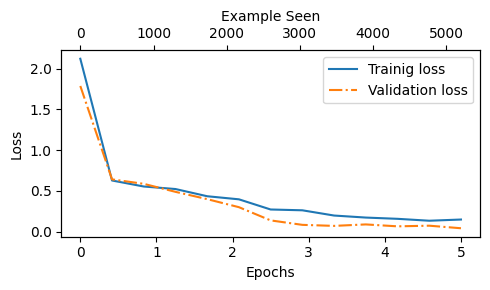

In [126]:
epochs_tensor = torch.linspace( 0 , num_epochs , len( train_losses ))
example_seen_tensor = torch.linspace( 0 , example_seen , len( train_losses ) )


plot_values( epochs_tensor , example_seen_tensor , train_losses , val_losses )

In [127]:
train_accuracy = calc_accuracy_loader( train_loader , model , device )
val_accuracy = calc_accuracy_loader( val_loader , model , device )
test_accuracy = calc_accuracy_loader( test_loader , model , device )

print( f"Training Accuracy : { train_accuracy * 100 :.2f} %")
print( f"validation Accuracy : { val_accuracy * 100 :.2f} %")
print( f"Test Accuracy : { test_accuracy * 100 :.2f} %")


Training Accuracy : 97.60 %
validation Accuracy : 98.66 %
Test Accuracy : 96.00 %


## Using the LLM as a Spam Classifier

In [128]:
def classify_review( text , model , tokenizer , device , max_length = None  , pad_token_id = 50256 ):
    model.eval()

    # prepare input to the model 
    input_ids = tokenizer.encode( text )
    supported_context_length = model.pos_emb.weight.shape[0]

    # Truncate the sequence if it is too long 
    input_ids = input_ids[ :min( max_length , supported_context_length )]

    #pad the sequence to the longest sequence 
    input_ids += [ pad_token_id ] * ( max_length - len( input_ids ))

    input_tensor = torch.tensor( input_ids , device= device ).unsqueeze( 0 )

    with torch.no_grad():
        logits = model( input_tensor )[ :, -1 ,: ]
    predicted_label = torch.argmax( logits , dim = -1 ).item()

    return "spam" if predicted_label == 1 else "not spam"


In [129]:
text1 = (
    "You are a winner you have been specially"
    " selected to receive $1000 cash or a $2000 award."
)

print( classify_review(
    text1 , model , tokenizer , device , max_length= train_dataset.max_length
))

spam


In [130]:
text2 = (
    "Hey, just wanted to check if we're still on"
    " for dinner tonight? Let me know!"
)

print(  classify_review(
    text2 , model , tokenizer , device , max_length= train_dataset.max_length
))

not spam


In [131]:
torch.save( model.state_dict() , "review_classifier.pth")

In [132]:
model_state_dict = torch. load("review_classifier.pth")
model. load_state_dict(model_state_dict)

/var/folders/n9/j8l4b0cj5zqdl0273gsv8jgh0000gn/T/ipykernel_51791/3826764412.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_state_dict = torch. load("review_classi

<All keys matched successfully>